# Implicit neural representation exercise 

This is a colab to summarize the main result of the exercise [Implicit Neural repreestaiton exercise](https://github.com/TalFurman/implicit_neural_representation_project).



Clone git repo 

In [1]:
!git clone https://github.com/TalFurman/implicit_neural_representation_project.git

Cloning into 'implicit_neural_representation_project'...
remote: Enumerating objects: 287, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 287 (delta 19), reused 0 (delta 0), pack-reused 135
Receiving objects: 100% (287/287), 4.11 MiB | 11.02 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [4]:
import sys
sys.path.insert(0,'/content/implicit_neural_representation_project')

In [5]:
from implicit_neural_representation_project.colab_example.MultiImageFIttingDataset import MultiImageFitting

Define dataset for multiple images 

In [6]:
import random

from skimage.color import rgba2rgb
from PIL import Image
from skimage.io import imread
from torch.utils.data import Dataset
import torch
import os
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
import pandas as pd
import cv2
import ast
import numpy as np
import copy

from colab_example.utils.dec_to_bin_utils import decimalToBinary, pad_bin_encode, get_max_binary_enc_len


def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid


class MultiImageFitting(Dataset):
    def __init__(self, sidelength: int,  path_to_images_csv: str = None, path_to_data : str = None,
                 as_gray_flag:bool = True, apply_mask: bool = False, mask_percent: float = 0.0, norm_mean: float = 0.5, norm_std: float = 0.5):
        """
        Dataset to handle loading and transforms for png from png database
        :param sidelength: side length of image in pixels
        :param path_to_images_csv: path to csv file with image names
        :param path_to_data: path the images
        :param as_gray_flag: if True convert to grayscale, else convert to RGB
        :param apply_mask: mask 'mask_percent' of the pixels in the image
        :param mask_percent: portion of pixels to be masked (only if apply_mask in True). From 0-1 (0 - none, 1 - all, 0.1 - 10%))
        :param norm_mean, norm_std: mean and std used for Normalize pytorch tansform
        """

        super().__init__()

        self.data_path = path_to_data

        self.as_gray = as_gray_flag
        self.apply_mask = apply_mask
        self.mask_percent = mask_percent
        self.norm_mean = norm_mean
        self.norm_std = norm_std
        self.num_channels =  1 if as_gray_flag else 3

        if not path_to_images_csv:
            path_to_images_csv = self.get_image_csv_from_data_path(path_to_data)
        image_metadata = pd.read_csv(path_to_images_csv)

        self.list_of_image_names = list(image_metadata['image_name'])
        self.max_binary_len = get_max_binary_enc_len(len(self))
        self.list_of_bin_encode = list(image_metadata['bin_encode'])

        self.sidelength = sidelength
        self.tot_num_pixels = sidelength * sidelength
        self.coords = get_mgrid(self.sidelength, 2)

    def __len__(self):
        return len(self.list_of_image_names)

    def __getitem__(self, idx):

        # Load img
        image_name = self.list_of_image_names[idx]

        image_path = os.path.join(self.data_path, image_name)

        # Original png (if not gray, then has 4 channels - RGBA)
        img = imread(image_path, as_gray=self.as_gray)

        img = Image.fromarray(img)

        # if not gray image, convert RGBA TO RGB
        if not self.as_gray:
            img = img.convert('RGB')

        transform = Compose([
            Resize(self.sidelength),
            ToTensor(),
            Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
        ])
        img = transform(img)

        mask = self._get_image_mask_tensor(idx)

        if self.as_gray:
            # Single color channel
            pixels = img.permute(1, 2, 0).view(-1, 1)
        else:
            # 3 color channels
            pixels = img.permute(1, 2, 0).view(-1, 3)

        # Get image binary encoding

        # transfer idx from decimal to binary
        img_bin_encode = torch.tensor(self._from_dec_to_bin_with_pad(idx))

        # Add each pixel with the binary encoding of the image (his number our of all available images
        img_bin_encode_repeat = img_bin_encode.repeat(len(self.coords),1)

        coord_and_bin_encode = torch.hstack((img_bin_encode_repeat, self.coords))

        return coord_and_bin_encode, pixels, mask

    def _get_image_mask_tensor(self, idx:int):
        # Create dummy mask
        mask = np.ones((self.sidelength, self.sidelength), dtype= bool).reshape(-1,1)

        # Decide which pixels to mask, and mask them
        if self.apply_mask:
            num_pixels_to_mask = int(self.tot_num_pixels * self.mask_percent)
            # Always mask the same pixels for a give image
            random.seed(idx)
            indeces_to_mask = random.sample(range(self.tot_num_pixels), num_pixels_to_mask)
            mask[indeces_to_mask] = False

        # Transform to pytorch tensor
        mask_tensor = torch.from_numpy(mask.reshape(self.sidelength, self.sidelength)).view(-1,1)

        assert mask_tensor.sum() > 0, "Masking all the image creates an irrelevant learning task, please avoid setting mask_percent to 1"

        if self.num_channels > 1:
            mask_tensor= mask_tensor.repeat((1, self.num_channels))

        return mask_tensor


    def _from_dec_to_bin_with_pad(self, dec_num: int) -> np.ndarray:
        """
        transform from int to padded binary encoding
        :return: np.ndarray padded binary encoding
        """
        binary_str = decimalToBinary(dec_num)

        return pad_bin_encode(num_to_encode=binary_str, max_bin_len=self.max_binary_len)

    @staticmethod
    def get_image_csv_from_data_path(path_to_data: str) -> str:
        """
        Find csv file in path to data
        (Assumption of single csv file)
        :param path_to_data: path to image data
        :return: path to csv file
        """

        list_of_csv_files = [file_name for file_name in os.listdir(path_to_data) if '.csv' in file_name]

        assert len(
            list_of_csv_files), f"No csv files where found under data path {path_to_data}, please make sure the csv file exist"

        path_to_csv = os.path.join(path_to_data, list_of_csv_files[0])

        return path_to_csv

Define main training script 


In [11]:
import argparse
import time
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from colab_example.MultiImageFIttingDataset import MultiImageFitting
from colab_example.Siren import Siren
from colab_example.utils.dec_to_bin_utils import get_max_binary_enc_len
from colab_example.utils.misc_utils import renormalize
import numpy as np
import random

import os


def run_multi_image_encoding(data_path:str, sidelength:int, num_encod_features: int = None, as_gray_flag: bool = True,
                             image_csv_path: str = None, checkpoints_dir: str = None, apply_mask: bool = False,
                             mask_percent: float = 0.0, norm_mean: float = 0.5, norm_std: float = 0.5, hidden_size: int = 48):

    # Define dataset
    png_image_dataset = MultiImageFitting(sidelength=sidelength, path_to_data=data_path, path_to_images_csv= image_csv_path,
                                          as_gray_flag= as_gray_flag, apply_mask= apply_mask,
                                          mask_percent= mask_percent, norm_mean=norm_mean, norm_std=norm_std)

    dataloader = DataLoader(png_image_dataset, batch_size=16, pin_memory=True, num_workers=0)

    # Calculate number of encoding input features
    if not num_encod_features:
        num_encod_features = get_max_binary_enc_len(len(png_image_dataset))

    # Number of image channels
    num_channels = 1 if as_gray_flag else 3

    # Model
    img_siren = Siren(in_features=2 + num_encod_features, out_features=num_channels, hidden_features=hidden_size,
                      hidden_layers=3, outermost_linear=True)
    img_siren.cuda()

    # Training params
    total_steps = 801  # Since the whole image is our dataset, this just means 500 gradient descent steps.
    steps_til_summary = 100
    step_til_checkpoint = 50
    optim = torch.optim.Adam(lr=5e-5, params=img_siren.parameters())

    # Initialize variables
    train_losses = list()
    tot_val_losses = list()
    step_vec = list()
    best_val_loss = None

    with tqdm(total=len(dataloader) * total_steps) as pbar:

        for step in range(total_steps):

            if not step % step_til_checkpoint and step:
                torch.save(img_siren.state_dict(),
                           os.path.join(checkpoints_dir, 'model_epoch_%04d.pth' % step))
                np.savetxt(os.path.join(checkpoints_dir, 'train_losses_epoch_%04d.txt' % step),
                           np.array(train_losses))
            start_time = time.time()
            curr_step_losses = list()
            for sample_ind, (model_input, ground_truth, mask) in enumerate(dataloader):

                model_input, ground_truth, mask = model_input.cuda(), ground_truth.cuda(), mask.cuda()
                model_output, coords = img_siren(model_input)
                loss = (mask*(model_output - ground_truth) ** 2).sum()/mask.sum()
                curr_step_losses.append(loss)
                optim.zero_grad()
                loss.backward()
                optim.step()
                pbar.update(1)

            train_losses.append(torch.sum(torch.stack(curr_step_losses)).cpu().detach().numpy())
            end_time = time.time()
            print(f"Single training loop time is {end_time - start_time} sec")

            if not step % steps_til_summary:

                print("Step %d, Mean train loss %0.6f" % (
                step, torch.mean(torch.stack(curr_step_losses)).cpu().detach().numpy()))
                print("Running validation set...")
                img_siren.eval()
                with torch.no_grad():
                    val_losses = list()
                    model_output_list = list()
                    ground_truth_list = list()
                    mask_list = list()
                    inverse_mask_list = list()

                    for (model_input, ground_truth, mask) in dataloader:
                        inverse_mask = mask.logical_not()
                        if not inverse_mask.sum():
                            inverse_mask=mask
                        model_input, ground_truth, inverse_mask, mask = model_input.cuda(), ground_truth.cuda(), inverse_mask.cuda(), mask.cuda()
                        model_output, coords = img_siren(model_input)
                        model_output_list.append(model_output)
                        ground_truth_list.append(ground_truth)
                        mask_list.append(mask)
                        inverse_mask_list.append(inverse_mask)
                        curr_val_loss = (inverse_mask * (
                                    model_output - ground_truth) ** 2).sum() / inverse_mask.sum()
                        val_losses.append(curr_val_loss)

                    print("Step %d, Mean val loss %0.6f" % (
                        step, torch.mean(torch.stack(val_losses)).cpu().detach().numpy()))

                    val_loss_for_step = torch.sum(torch.stack(val_losses)).cpu().detach().numpy()
                    tot_val_losses.append(val_loss_for_step)
                    step_vec.append(step)

                    # Update best model according to validation loss

                    if best_val_loss is None or val_loss_for_step < best_val_loss:
                        best_val_loss = val_loss_for_step
                        torch.save(img_siren.state_dict(),
                                   os.path.join(checkpoints_dir, 'best_model_by_val.pth'))
                        np.savetxt(os.path.join(checkpoints_dir, 'loss_for_best_model_epoch_%04d.txt' % step),
                                   best_val_loss.reshape(-1 , 1))

                    # Make dir for artifacts
                    artifact_dir_path = os.path.join(checkpoints_dir, 'artifacts')
                    if not os.path.exists(artifact_dir_path):
                        os.mkdir(artifact_dir_path)

                    # Create figure to track loss
                    #print(f"Current validation loss in step {step} is {val_loss_for_step}")
                    fig, ax = plt.subplots(figsize=(12, 6))
                    ax.plot(step_vec, tot_val_losses, color='blue',
                            label= 'val loss')
                    ax.plot(train_losses, color='red',
                            label= 'train loss')
                    ax.legend(loc="upper left")
                    ax.set_title(
                        f'train and validation losses for {mask_percent * 100}% masked pixels (about {int(inverse_mask[0].sum().cpu().detach().numpy()/num_channels)} pixels)')
                    plt.xlim([0, total_steps])
                    plt.xlabel('Step (epoch)')
                    plt.ylabel('MSE (per pixel)')
                    fig_name_loss = f"train_val_mse_loss_graph_step_{step}.png"
                    plt.savefig(os.path.join(artifact_dir_path, fig_name_loss))
                    if step > 0:
                      plt.show()
                    # Create figures with example train/val image
                    num_sampled_ind = 3 if len(dataloader) > 3 else len(dataloader)
                    random.seed(step)
                    chosen_model_output_list = random.sample(model_output_list, num_sampled_ind)
                    random.seed(step)
                    chosen_ground_truth_list = random.sample(ground_truth_list, num_sampled_ind)

                    fig_train, axes_train = plt.subplots(3, len(chosen_model_output_list), figsize=(18, 9))

                    for output_num, (model_output, ground_truth, mask) in enumerate(zip(chosen_model_output_list, chosen_ground_truth_list, mask_list)):
                        model_output_train = model_output[0]
                        ground_truth_train = ground_truth[0]

                        # renormalize (was normalized during data preparation
                        pred_image = renormalize(model_output_train.cpu().view(sidelength, sidelength, num_channels).detach().numpy().squeeze(), norm_std, norm_mean)
                        gt_image = renormalize((ground_truth_train.cpu().view(sidelength, sidelength, num_channels).detach().numpy().squeeze()), norm_std, norm_mean)
                        gt_image_masked = gt_image * mask[0].cpu().view(sidelength, sidelength, num_channels).detach().numpy().squeeze()

                        # Save results
                        axes_train[0, output_num].imshow(pred_image)
                        axes_train[0, output_num].set_title('Predicted image')
                        axes_train[1, output_num].imshow(gt_image_masked)
                        axes_train[1, output_num].set_title('Masked (input) image')
                        axes_train[2, output_num].imshow(gt_image)
                        axes_train[2, output_num].set_title('GT image')
                        plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.35, wspace=0)

                    file_name_train_images = f'sampled masked train images step {step}'
                    fig_train.savefig(os.path.join(artifact_dir_path, file_name_train_images))
                    if step > 0:
                      plt.show()
                img_siren.train()
    
    torch.save(img_siren.state_dict(),
               os.path.join(checkpoints_dir, 'model_final.pth'))
    np.savetxt(os.path.join(checkpoints_dir, 'train_losses_final.txt'),
               np.array(train_losses))


Run training for 48 res dataset 

In [ ]:

# Define run arguments

# path to folder with images
data_path = '/content/implicit_neural_representation_project/execrsize_data/48'
# path to csv with relevant image names (can be a subset of the data)
csv_path = '/content/implicit_neural_representation_project/execrsize_data/48/image_paths.csv'
# image size (side)
sidelength = 48
# hidden layer size 
hidden_size = sidelength * 10
# bool - mask some of the pixles
apply_mask = True
# how many pixels to mask from image - going from 0 -> None up to 1 -> all image
mask_percent = 0.1 
# value of mean for image normalization with pytorch transform Normalize
norm_mean = 0.5
# value of std for image normalization with pytorch transform Normalize
norm_std = 0.5
# run experiment in grayscale
as_gray_flag = False
# experiment name
exp_name = 'colab_experiment_train_on_48_db'


experiment_dir = os.path.join('/content/implicit_neural_representation_project/colab_example','experiments')
if not os.path.exists(experiment_dir):
    os.mkdir(experiment_dir)
checkpoints_dir =  os.path.join(experiment_dir,exp_name)
if not os.path.exists(checkpoints_dir):
    os.mkdir(checkpoints_dir)
run_multi_image_encoding(data_path=data_path, sidelength=sidelength, as_gray_flag=as_gray_flag,
                         image_csv_path=csv_path, checkpoints_dir=checkpoints_dir, apply_mask= apply_mask,
                         mask_percent= mask_percent, norm_mean=norm_mean, norm_std=norm_std, hidden_size= hidden_size)

  0%|          | 6/5607 [00:00<06:11, 15.10it/s]

Single training loop time is 0.46631884574890137 sec
Step 0, Mean train loss 0.492192
Running validation set...
Step 0, Mean val loss 0.379600


  0%|          | 17/5607 [00:01<07:37, 12.21it/s]

Single training loop time is 0.3786337375640869 sec


  0%|          | 24/5607 [00:02<05:53, 15.77it/s]

Single training loop time is 0.38140416145324707 sec


  1%|          | 31/5607 [00:02<05:22, 17.30it/s]

Single training loop time is 0.4043724536895752 sec


  1%|          | 38/5607 [00:02<05:06, 18.20it/s]

Single training loop time is 0.3836183547973633 sec


  1%|          | 45/5607 [00:03<05:04, 18.28it/s]

Single training loop time is 0.38631510734558105 sec


  1%|          | 52/5607 [00:03<05:01, 18.44it/s]

Single training loop time is 0.3879878520965576 sec


  1%|          | 59/5607 [00:04<05:01, 18.40it/s]

Single training loop time is 0.3857097625732422 sec


  1%|          | 66/5607 [00:04<05:00, 18.43it/s]

Single training loop time is 0.3925974369049072 sec


  1%|▏         | 73/5607 [00:04<05:03, 18.25it/s]

Single training loop time is 0.3919863700866699 sec


  1%|▏         | 80/5607 [00:05<05:00, 18.39it/s]

Single training loop time is 0.38824033737182617 sec


  2%|▏         | 87/5607 [00:05<05:00, 18.38it/s]

Single training loop time is 0.3879880905151367 sec


  2%|▏         | 94/5607 [00:06<05:01, 18.27it/s]

Single training loop time is 0.3910346031188965 sec


  2%|▏         | 101/5607 [00:06<05:02, 18.18it/s]

Single training loop time is 0.39507603645324707 sec


  2%|▏         | 108/5607 [00:06<05:00, 18.28it/s]

Single training loop time is 0.39002490043640137 sec


  2%|▏         | 115/5607 [00:07<04:58, 18.41it/s]

Single training loop time is 0.39011716842651367 sec


  2%|▏         | 117/5607 [00:07<05:07, 17.87it/s]

Define validation class (for upsampling and image interpolation)

In [42]:
import argparse
import time
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from implicit_neural_representation_project.colab_example.MultiImageFIttingDataset import MultiImageFitting
from implicit_neural_representation_project.colab_example.Siren import Siren
from implicit_neural_representation_project.colab_example.utils.dec_to_bin_utils import get_max_binary_enc_len
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import os

from implicit_neural_representation_project.colab_example.utils.misc_utils import renormalize

class EvalImageInterpolation:
    
    def __init__(self, data_low_path:str , data_high_path:str,  sidelength_low: int,  sidelength_high: int, num_encod_features: int = None, as_gray_flag: bool = True,
                             image_csv_path_low: str = None, image_csv_path_high: str = None, checkpoints_dir: str = None, apply_mask: bool = False,
                             mask_percent: float = 0.0, model_to_load: str = 'best'
                            ,norm_mean: float = 0.5, norm_std: float = 0.5, hidden_size:int = 48, num_steps:int = 10):

        self.sidelength_low = sidelength_low
        self.sidelength_high = sidelength_high

        self.low_res_datastet =  MultiImageFitting(path_to_data= data_low_path, sidelength=sidelength_low, path_to_images_csv= image_csv_path_low,
                                          as_gray_flag= as_gray_flag, apply_mask= apply_mask, mask_percent= mask_percent)

        self.high_res_datastet =  MultiImageFitting(path_to_data= data_high_path, sidelength=sidelength_high, path_to_images_csv= image_csv_path_high,
                                          as_gray_flag= as_gray_flag, apply_mask= apply_mask, mask_percent= mask_percent)

        self.norm_std = norm_std
        self.norm_mean = norm_mean

        # Calculate number of encoding input features
        if not num_encod_features:
            self.num_encod_features = get_max_binary_enc_len(len(self.low_res_datastet))
        else:
            self.num_encod_features = num_encod_features
        # Number of image channels
        self.num_channels = 1 if as_gray_flag else 3

        # Number of steps for interpolation between images
        self.num_interp_steps = num_steps

        # Model
        self.img_siren = Siren(in_features=2 + num_encod_features, out_features=self.num_channels,
                          hidden_features=hidden_size,
                          hidden_layers=3, outermost_linear=True)

        self.img_siren.cuda()
        self.img_siren.eval()

        # Load checkpoint
        model_path = self.get_model_path(checkpoints_dir, model_to_load)
        self.img_siren.load_state_dict(torch.load(model_path))

        # Artifacts path
        self.artifact_dir_path = os.path.join(checkpoints_dir, 'artifacts')

    def upsample_image(self, num_examples: int = 3, random_img_flag: bool = False):
        """
        Demonstrate upsampling capabilities 
        :param num_examples: number of examples to upsample
        :param random_img_flag: bool, if False random seed is fixed and same images would be retrieved each time
        """

        if not random_img_flag:
            # The 256 DB has some strange black background effect non-present in training set. The following image indeces have white background
            random_image_inds = [0,8, 62]
        else:
            random_image_inds = random.sample(range(len(self.low_res_datastet)), num_examples)

        # Define result lists
        gt_high_res_list = list()
        gt_low_res_list = list()
        upsampled_list = list()

        # Upsample
        for img_num in random_image_inds:

            # Take input coords and GT images from high res dataset
            model_input_high_res, ground_truth_high, _ = self.high_res_datastet[img_num]

            gt_high_res_list.append(ground_truth_high)

            # Take the GT images from the low res dataset
            model_input_low_re, ground_truth_low, _ = self.low_res_datastet[img_num]

            gt_low_res_list.append(ground_truth_low)

            # Predict (up-sample) with model trained on low res
            model_input_high_res = model_input_high_res.unsqueeze(0).cuda()


            model_output_high_res, _ = self.img_siren(model_input_high_res)
            upsampled_list.append(model_output_high_res)

        # Visualize results
        fig_train, axes_train = plt.subplots(3, len(upsampled_list), figsize=(18, 9))

        for output_num, (model_output, ground_truth_low, ground_truth_high) in enumerate(zip(upsampled_list, gt_low_res_list, gt_high_res_list)):

            # renormalize (was normalized during data preparation
            pred_image = renormalize(model_output.cpu().view( self.sidelength_high, self.sidelength_high, self.num_channels).detach().numpy().squeeze(),
                self.norm_std, self.norm_mean)
            gt_high_res_image = renormalize(
                (ground_truth_high.cpu().view(self.sidelength_high, self.sidelength_high, self.num_channels).detach().numpy().squeeze()),
                self.norm_std, self.norm_mean)
            gt_low_res_image = renormalize(
                (ground_truth_low.cpu().view(self.sidelength_low, self.sidelength_low, self.num_channels).detach().numpy().squeeze()), self.norm_std, self.norm_mean)

            # Save results
            axes_train[0, output_num].imshow(pred_image)
            axes_train[0, output_num].set_title('upsampled image')
            axes_train[1, output_num].imshow(gt_high_res_image)
            axes_train[1, output_num].set_title('GT high res image')
            axes_train[2, output_num].imshow(gt_low_res_image)
            axes_train[2, output_num].set_title('GT low res image')
            plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.35, wspace=0)

        file_name_train_images = f"upsample_from_{self.sidelength_low}_to_{self.sidelength_high}"

        fig_train.savefig(os.path.join(self.artifact_dir_path, file_name_train_images))
        plt.show()


    def interpolate_between_image_pairs(self, num_chosen_pairs: int = 3, low_similarity: bool = True):

        # Extract the embedding of the different images by the network (taking the last hidden layer activations

        img_activations_list = list()
        img_list = list()

        for sample_ind, (model_input, ground_truth, mask) in enumerate(tqdm(self.low_res_datastet)):
            model_input, ground_truth, mask = model_input.cuda(), ground_truth.cuda(), mask.cuda()
            activations = self.img_siren.forward_with_activations(model_input)
            img_list.append(ground_truth.cpu().detach().view(self.sidelength_low, self.sidelength_low, self.num_channels).numpy())
            # The last feature map (After sine operation) is saved under 7th activation
            last_hidden_activation = activations["<class 'implicit_neural_representation_project.colab_example.Siren.SineLayer'>_7"].cpu().detach().numpy()
            img_activations_list.append(last_hidden_activation.reshape(-1,1))

        # calculate similarity between each image pair
        img_activations_array = np.array(img_activations_list).reshape(100,-1)
        represent_similarity = np.array(cosine_similarity(img_activations_array))

        # Replace diagonal values (close to 1) with average value in matrix (so they won't reflect on highest/lowest values)
        mat_dim = represent_similarity.shape[0]
        mean_similarity_val = represent_similarity.mean()
        represent_similarity[range(mat_dim), range(mat_dim)] = mean_similarity_val

        for i in range(2):
            # Hack !!! - replace max disimilarity with mean value (appears in all disimmilar pairs)
            represent_similarity[np.where(represent_similarity == represent_similarity.min())] = mean_similarity_val

        # Fine num_chosen_pairs of images with least similarity
        smallest_similarity_array = self.smallest_highest_N_indices(represent_similarity, 2*num_chosen_pairs, low_similarity)

        # Skip over repeating values (due to similiarity matrix symmetry)
        smallest_similarity_array = smallest_similarity_array[::2]


        # Do interpolation for each pair

        # Visualize image pairs
        fig, axes = plt.subplots(2, num_chosen_pairs, figsize=(18, 6))

        # For each pair

        all_interped_arrays = list()

        for num_img_pair, ind_vec in enumerate(smallest_similarity_array):
            img_1 = img_list[ind_vec[0]]
            img_2 = img_list[ind_vec[1]]

            # Visualize image pairs
            axes[0, num_img_pair].imshow(img_1)

            fig_name_str = 'similar' if low_similarity == False else 'disimilar'

            axes[0, num_img_pair].set_title( fig_name_str +  f' pair {num_img_pair}')
            axes[1, num_img_pair].imshow(img_2)

            hidden_img1 = img_activations_list[ind_vec[0]]
            hidden_img2 = img_activations_list[ind_vec[1]]

            interp_vec_array = self.interpolate_points(hidden_img1, hidden_img2, n_steps= self.num_interp_steps)

            all_interped_arrays.append(interp_vec_array)
        plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.35, wspace=0)

        file_name_train_images = "Image pairs chosen for interpolation with " + fig_name_str
        fig.savefig(os.path.join(self.artifact_dir_path, file_name_train_images))
        plt.show()
        
        # Show the interpolations

        # Visualize image intepolation
        fig, axes = plt.subplots(num_chosen_pairs, self.num_interp_steps, figsize=(18, 6))
        
        for interp_ind in range(len(all_interped_arrays)):
            curr_interped_array = all_interped_arrays[interp_ind]

            for interp_sub_ind in range(len(curr_interped_array)):
                # Prepare interpolated activation
                interp_activation = torch.tensor(curr_interped_array[interp_sub_ind]).squeeze()
                interp_activation = interp_activation.view(last_hidden_activation.shape[0], last_hidden_activation.shape[1]).cuda()
                activations["<class 'implicit_neural_representation_project.colab_example.Siren.SineLayer'>_7"] = interp_activation

                # Interpolate
                new_activations = self.img_siren.forward_with_activations(activations=activations, embedding_layer_name= "<class 'implicit_neural_representation_project.colab_example.Siren.SineLayer'>_7")
                new_image = new_activations["<class 'torch.nn.modules.linear.Linear'>_8"].view(self.sidelength_low,self.sidelength_low,-1).cpu().detach().numpy()

                # renormalize (was normalized during data preparation
                pred_image = renormalize(new_image, self.norm_std, self.norm_mean)

                # Save results
                axes[interp_ind, interp_sub_ind].imshow(pred_image)
                axes[interp_ind, interp_sub_ind].axis('off')
        plt.subplots_adjust(top=0.98, bottom=0.01, hspace=0.0, wspace=0)
        file_name_iterp_images = f"Interpolation between pairs of {fig_name_str} images"
        fig.suptitle(file_name_iterp_images)
        fig.savefig(os.path.join(self.artifact_dir_path, file_name_iterp_images))
        plt.show()

    @staticmethod
    def transform_to_0_to_1(input_vec: np.ndarray):
        return (input_vec - input_vec.min())/(input_vec.max()-input_vec.min())

    @staticmethod
    def smallest_highest_N_indices(input_mat: np.ndarray, num_of_min_values: int, low_similarity:bool = True) -> np.ndarray:
        """
        Find #num_of_min_values minimal values indeces in an nd.array
        :param input_mat: nd array
        :param num_of_min_values: required number
        :param smalest: bool if true return N smallest, else N largest values
        :return: array with pairs of minimal values
        """
        if low_similarity:
            idx = input_mat.ravel().argsort()[:num_of_min_values]
        else:
            idx = input_mat.ravel().argsort()[-num_of_min_values:]
        return np.stack(np.unravel_index(idx, input_mat.shape)).T

    @staticmethod
    def interpolate_points(p1, p2, n_steps=10):
        # interpolate ratios between the points
        ratios = np.linspace(0, 1, num=n_steps)
        # linear interpolate vectors
        vectors = list()
        for ratio in ratios:
            v = (1.0 - ratio) * p1 + ratio * p2
            vectors.append(v)
        return np.asarray(vectors)

    @staticmethod
    def get_model_path(checkpoints_dir: str, model_to_load: str = 'best'):
        """
        return path to of relevant model
        :param checkpoints_dir: path to checkpoints
        :param model_to_load: best or last
        :return:
        """
        if model_to_load.lower() == 'best':
            model_path = os.path.join(checkpoints_dir, 'best_model_by_val.pth')
        elif model_to_load.lower() == 'last':
            model_path = os.path.join(checkpoints_dir, 'model_final.pth')
        else:
            raise ValueError(
                'Only last or best model types are valid for loading. please check the relevant argument input')
        return model_path
        

Init validation class with relevant params

In [43]:
# Define run arguments

data_low_path =  '/content/implicit_neural_representation_project/execrsize_data/48'
data_high_path =  '/content/implicit_neural_representation_project/execrsize_data/256'
csv_low_path =  '/content/implicit_neural_representation_project/execrsize_data/48/image_paths.csv'
csv_high_path = '/content/implicit_neural_representation_project/execrsize_data/256/image_paths.csv'
sidelength_low = 48
sidelength_high = 256
hidden_size = 48*10
apply_mask = False
mask_percent = 0.0
as_gray_flag = False
exp_name = 'colab_experiment_train_on_48_db'
model_to_load = 'best'
num_encod_features = 7
norm_mean = 0.5
norm_std = 0.5
experiment_dir = '/content/implicit_neural_representation_project/colab_example/experiments'
checkpoints_dir =  os.path.join(experiment_dir, exp_name)


eval_image_interp = EvalImageInterpolation(data_low_path= data_low_path, data_high_path=data_high_path, sidelength_low= sidelength_low,  sidelength_high= sidelength_high, num_encod_features= num_encod_features,
                            as_gray_flag= as_gray_flag, image_csv_path_low= csv_low_path, image_csv_path_high= csv_high_path, checkpoints_dir= checkpoints_dir, apply_mask= apply_mask,
                            mask_percent= mask_percent, model_to_load= model_to_load, norm_mean= norm_mean, norm_std= norm_std, hidden_size= hidden_size)


Run upsampling 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


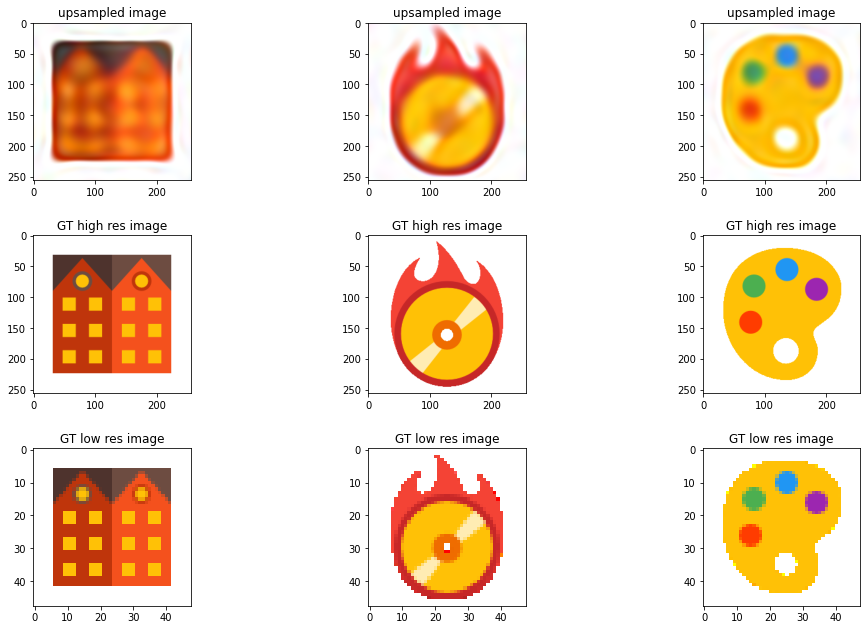

In [41]:

# image upsampling
eval_image_interp.upsample_image()

Run intepolation between disimilar embeddings 

100%|██████████| 100/100 [00:00<00:00, 212.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


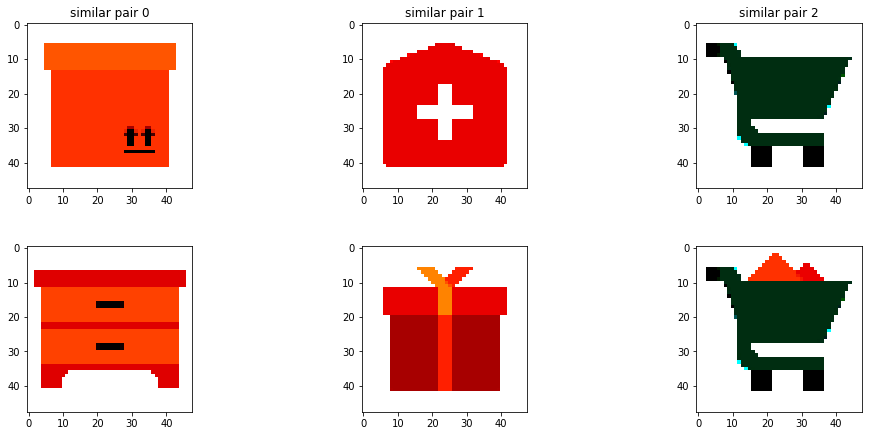

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

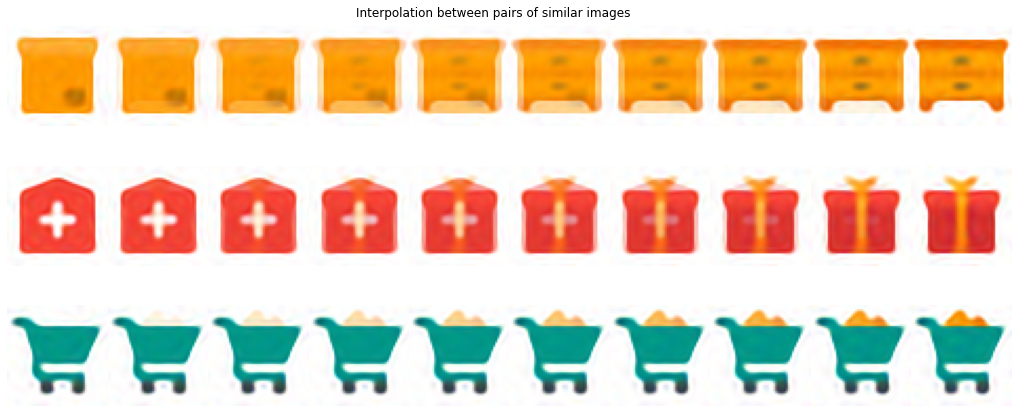

In [44]:
# interpolating between images with disimilar embedding 
eval_image_interp.interpolate_between_image_pairs(low_similarity=False)


Run interpolation between similar embeddings

100%|██████████| 100/100 [00:00<00:00, 215.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


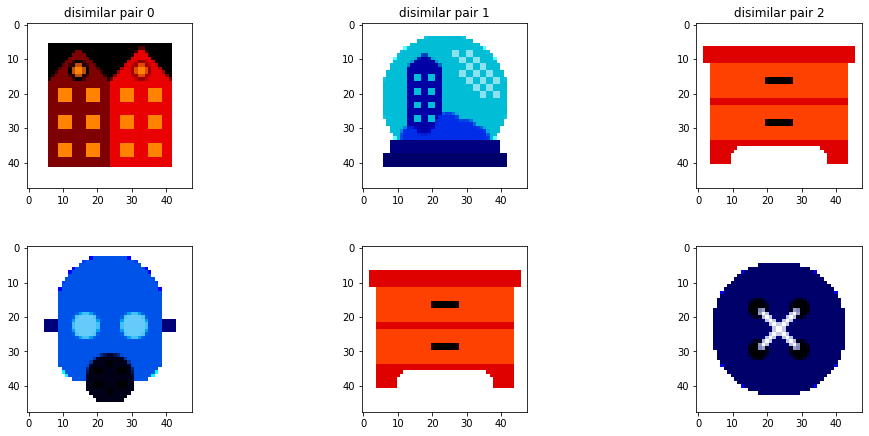

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

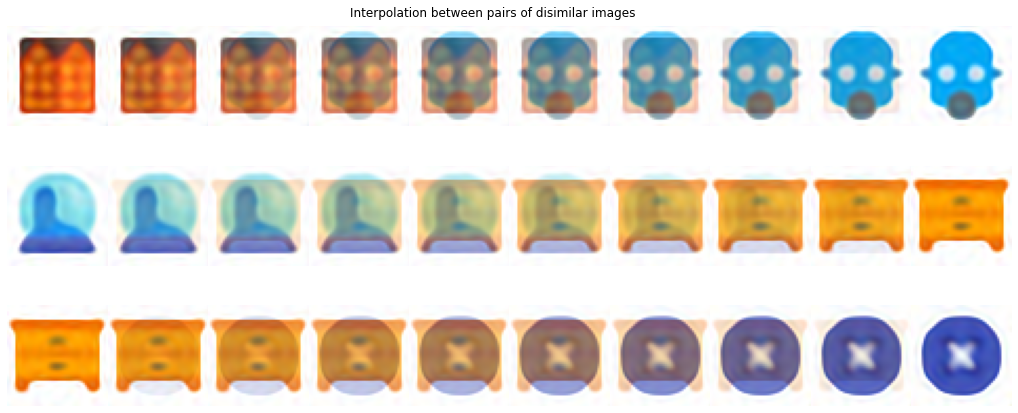

In [45]:
# interpolating between images with similar embedding 
eval_image_interp.interpolate_between_image_pairs(low_similarity=True)